```adjacent_matrix = {node: {node:weight}}```

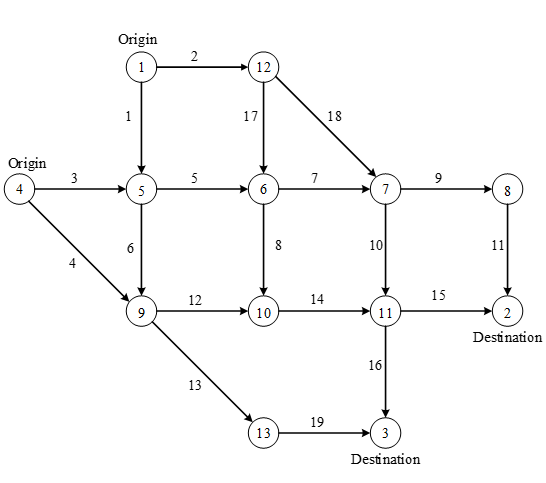

In [14]:
import heapq
import numpy as np
from scipy.optimize import newton
import time

class TrafficDistributionModel:
    def __init__(self, edges, traffic_demand, free_flow_time, link_capacity):
        print('------------------初始化-----------------')
        self.edgeList = edges
        self.traffic_demand = traffic_demand
        self.edges_num = len(self.edgeList)
        self.vertexList = self.edge2vertex()

        self.free_flow_time = free_flow_time
        self.link_capacity = link_capacity
        # traffic_flow -> edge cost -> adjacency matrix -> find shortest path
        
        self.traffic_flow = np.zeros(self.edges_num)
        self.cost = self.update_cost()
        self.adjacency_matrix = self.create_adjacency_matrix()
        self.traffic_flow = self.all_in_out_distribution()
        print(f'图的节点有{self.vertexList}')

        self.iter_num = 0

    def edge2vertex(self):
        vertex_list = set()
        for _, edge in self.edgeList.items():
            vertex_list.add(edge[0])
            vertex_list.add(edge[1])
        return list(vertex_list)


    def BPR(self, x, t0, Ca):
        """
        alpha = 0.15, beta = 4
        """
        return t0 * (1+0.15*(x/Ca)**4)
    
    def update_cost(self):
        new_cost = {}
        for i, flow in enumerate(self.traffic_flow):
            new_cost[i+1] = self.BPR(flow, self.free_flow_time[i], self.link_capacity[i])
        return new_cost

    def create_adjacency_matrix(self):
        adjacency_matrix = {}
        for id, edge in self.edgeList.items():
            if edge[0] not in adjacency_matrix:
                adjacency_matrix[edge[0]] = {edge[1]: self.cost[id]}
            else:
                adjacency_matrix[edge[0]][edge[1]] = self.cost[id]
        return adjacency_matrix

    def dijkstra_with_path(self, start, end):
        graph = self.adjacency_matrix
        vertexList = self.vertexList

        distances = {vertex: float('infinity') for vertex in vertexList}
        distances[start] = 0
        predecessors = {vertex: None for vertex in vertexList}  # 保存前驱节点信息
        priority_queue = [(0, start)]

        while priority_queue:
            current_distance, current_vertex = heapq.heappop(priority_queue)

            if current_distance > distances[current_vertex]:
                continue

            if current_vertex not in graph:
                continue

            for neighbor, weight in graph[current_vertex].items():
                distance = current_distance + weight

                if distance < distances[neighbor]:
                    distances[neighbor] = distance
                    predecessors[neighbor] = current_vertex  # 保存前驱节点
                    heapq.heappush(priority_queue, (distance, neighbor))
        path = []
        current_vertex = end
        while current_vertex is not None and current_vertex != start:
            path.append(current_vertex)
            current_vertex = predecessors[current_vertex]
        if current_vertex is None:
            return "No path exists."
        path.append(start)
        # print(f'从{start}到{end}的最短路为{path[::-1]}')
        return path[::-1]
    

    def all_in_out_distribution(self):
        # 全有全无分配之前更新一下权重，并构建邻接目录作为dijkstra的输入
        self.cost = self.update_cost()
        self.adjacency_matrix = self.create_adjacency_matrix()
        
        traffic_flow = np.zeros(self.edges_num)
        inverted_dict = {v: k for k, v in self.edgeList.items()}
        for o, d, q in self.traffic_demand:
            path = self.dijkstra_with_path(o, d)
            for edge in list(zip(path[:-1], path[1:])):
                traffic_flow[inverted_dict[edge]-1] = q
        return traffic_flow
    
    def find_zero_point(self, func, low=0.0, high=1.0, tolerance=1e-2):
        # 初始条件：确保函数在 low 和 high 处的值有正负号变化
        if func(low) * func(high) >= 0:
            print("函数在给定区间内无零点或无法确定零点位置。")
            return None

        while abs(high - low) > tolerance:
            mid = (low + high) / 2
            # 如果中间点的函数值接近零，可以认为已经找到零点
            if abs(func(mid)) < tolerance:
                return mid

            # 根据中间点的符号和边界值的符号确定新的搜索范围
            if func(mid) * func(low) < 0:
                high = mid
            else:
                low = mid

        return (low + high) / 2

    def Frank_Worlf(self, epslion=1e-4, alg=1):
        """
        --alg:
        0: 自己写的二分法 但是解的范围难以估计 导致会过快收敛
        1: scipy.optimize中的newtons求解
        2: 固定的减速步长 有可能会不收敛 全看随机数
        # TODO: 有没有更好的求解方法 或者上述的问题该如何解决
        """
        if alg == 2:
            steps = [1/i for i in range(2, 1000) for _ in range(i)]
        
        dic = {0:'二分法', 1:'牛顿法', 2:'固定减速步长'}
        print(f'搜索算法采用{dic[alg]}')

        iter_num = 0
        time_list = []
        while True:
            start = time.time()
            iter_num += 1

            if alg==0 or alg ==1:
                print(f'--------------第{iter_num}次迭代---------------')
                
            x = self.traffic_flow
            y = self.all_in_out_distribution()
            
            def func(alpha):
                res = 0
                bpr_input = x + alpha*(y-x)
                direction = y - x
                for i in range(self.edges_num):
                    res += self.BPR(bpr_input[i], self.free_flow_time[i], self.link_capacity[i]) * direction[i]
                return res
            
            if alg == 0:
                alpha = self.find_zero_point(func)
            elif alg == 1:
                alpha = newton(func, x0=0)
            elif alg == 2:
                alpha = steps[iter_num-1]
            
            if not alpha:
                print('无法找到最优的alpha步长')
                print(self.traffic_flow)
                print(f'最终的loss为{loss}')
                break
            if alg == 0 or alg == 1:
                print(f'alpha的值为{alpha}')
            self.traffic_flow = x + alpha*(y-x)
            # print(f'交通流量的值为{self.traffic_flow}')

            end = time.time()
            time_list.append(end-start)

            loss  = np.linalg.norm((x-self.traffic_flow))/x.sum()
            # print(f'loss为{loss}')

            if loss < epslion:
                print(f'迭代{iter_num}轮收敛')
                print(f'最终的loss为{loss}')
                # print(alpha)               
                print(f'时间花费{np.array(time_list).sum()}')
                print(f'交通流量的值为{self.traffic_flow}')
                break

    def MSA(self, epslion=1e-4):
        # 生成足够长的减速步长
        steps = [1/i for i in range(2, 1000) for _ in range(i)]
        iter_num = 0
        time_list = []
        while True:
            start = time.time()
            alpha = steps[iter_num]
            iter_num += 1
            # print(f'--------------第{iter_num}次迭代---------------')
            x = self.traffic_flow
            F = self.all_in_out_distribution()
            self.traffic_flow = (1-alpha)*x + alpha*F
            # print(f'交通流量的值为{self.traffic_flow}')
            
            end = time.time()
            loss  = np.linalg.norm((x-self.traffic_flow))/x.sum()
            # print(f'loss为{loss}')
            time_list.append(end-start)
            if loss < epslion:
                print(f'迭代{iter_num}轮收敛')
                print(f'时间花费{np.array(time_list).sum()}')
                print(f'loss为{loss}')
                print(f'交通流量的值为{self.traffic_flow}')
                break

    def reSetAll(self):
        # TODO:是否需要增强函数封装性，迭代过程中不对self.traffic_flow进行更改
        # 由于FrankWorlf,MSA算法都是直接对self.traffic_flow的更改,这里添加一个对self.traffic_flow的归零操作
        self.traffic_flow = np.zeros(self.edges_num)
        self.cost = self.update_cost()
        self.adjacency_matrix = self.create_adjacency_matrix()
        self.traffic_flow = self.all_in_out_distribution()

        self.iter_num = 0


    def getTrafficFlow(self):
        return self.traffic_flow

# 输入严格按照边的序号顺序
free_flow_time_list = [7.0, 9.0, 9.0, 12.0, 3.0, 9.0, 5.0, 13.0, 5.0, 9.0, 9.0, 10.0, 9.0, 6.0, 9.0, 8.0, 7.0, 14.0, 11.0]
link_capacity_list = [800, 400, 200, 800, 350, 400, 800, 250, 250, 300, 550, 550, 600, 700, 500, 300, 200, 400, 600]
edges_list = [(1,5),(1,12),(4,5),(4,9),(5,6),(5,9),(6,7),(6,10),(7,8),(7,11),(8,2),(9,10),(9,13),
         (10,11),(11,2),(11,3),(12,6),(12,7),(13,3)]

edges = {}
for i, edge in enumerate(edges_list):
    edges[i+1] = edge
traffic_demand = [(1,2,500), (1,3,400), (4,2,500), (4,3,400)]

model = TrafficDistributionModel(edges, traffic_demand=traffic_demand, free_flow_time=free_flow_time_list, 
                                 link_capacity=link_capacity_list)

------------------初始化-----------------
图的节点有[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [10]:
model.Frank_Worlf(alg=0)

搜索算法采用二分法
--------------第1次迭代---------------
alpha的值为0.45703125
--------------第2次迭代---------------
alpha的值为0.01171875
--------------第3次迭代---------------
函数在给定区间内无零点或无法确定零点位置。
无法找到最优的alpha步长
[400.           0.         268.30291748 400.         500.
 185.35766602 500.           0.         274.16229248 440.4800415
 274.16229248 231.69708252 400.         231.69708252 231.69708252
 214.64233398   0.           0.         400.        ]
最终的loss为0.001971439504833865


In [11]:
model.reSetAll()
model.Frank_Worlf(alg=1)

搜索算法采用牛顿法
--------------第1次迭代---------------
alpha的值为0.4547669171808118
--------------第2次迭代---------------
alpha的值为0.01180589883948528
--------------第3次迭代---------------
alpha的值为2.635988295316647e-15
迭代3轮收敛
最终的loss为4.314496947059566e-16
时间花费0.0019941329956054688
交通流量的值为[400.           0.         269.3980581  400.         500.
 184.48155352 500.           0.         275.30100752 440.21743896
 275.30100752 230.6019419  400.         230.6019419  230.6019419
 215.51844648   0.           0.         400.        ]


In [15]:
model.reSetAll()
model.Frank_Worlf(alg=2)

搜索算法采用固定减速步长0
迭代63574轮收敛
最终的loss为9.994503315362352e-05
时间花费6.868452787399292
交通流量的值为[400.           0.          44.23284962 400.         427.79310395
  80.14151393 427.79310395   0.         427.32299776 330.41169944
 427.32299776 455.76715038 400.         455.76715038 455.76715038
 319.85848607   0.           0.         400.        ]


In [13]:
model.reSetAll()
model.MSA()

迭代63574轮收敛
时间花费6.93543267250061
loss为9.994503315363098e-05
交通流量的值为[400.           0.          44.23284962 400.         427.79310395
  80.14151393 427.79310395   0.         427.32299776 330.41169944
 427.32299776 455.76715038 400.         455.76715038 455.76715038
 319.85848607   0.           0.         400.        ]


# 总结
求解FrankWorlf算法的难点在于步长的求解
1. 二分法由于需要预设两端的点，且只有当两端异号时才会激活，这会导致有时找不到最优步长，尤其是在第三步迭代时，$\alpha$的值只有1e-15,只是单纯的二分法很难找到这个点。
2. 牛顿法只需给定起始点，但要求函数可导，调包执行，效果最佳
3. 固定减速步长收敛全靠运气，运行时间非常的慢 